In [2]:
# %load '/home/wes/dev/frc/tba-pydata/tba_pydata/api.py'
from enum import Enum
from multiprocessing import Pool

import requests
import pandas
import re

from tba_pydata import constants

TBA = 'https://www.thebluealliance.com/api/v3'
HEADER = {'X-TBA-Auth_Key': 'SfIaTaudX9MLcouEO0NbEktueyhKcNJ8PlBlrHuw4yXWx1D30fVQxtLHERg7QZVG'}
YEAR = 2017

TEAM_REGEX = re.compile(r'frc([0-9]+).*')

# TODO: format = 'list'

def tba_fetch(path):
    resp = requests.get(TBA + path, headers=HEADER)
    print(TBA + path, resp.status_code)
    return resp.json()


def tba_fetch_many(paths, concat=True):
    pool = Pool()
    res = pool.map(tba_fetch, paths)

    if not concat:
        return res

    total = []
    for sublist in res:
        total += sublist

    return total


def normalize_team_key(team, out_format='tba'):
    if isinstance(team, int):
        if out_format == 'int':
            return team
        elif out_format == 'str':
            return 'frc%04d' % team
        elif out_format == 'tba':
            return 'frc%d' % team
        else:
            return None
    elif isinstance(team, str):
        matches = TEAM_REGEX.match(team)
        if matches:
            num = matches.group(1)
            if out_format == 'str':
                return 'frc%04d' % int(num)
            elif out_format == 'int':
                return int(num)
            elif out_format == 'tba':
                return 'frc%d' % int(num)
        else:
            return normalize_team_key(int(team), out_format)


def opp(alliance):
    alliance = alliance.lower()
    return 'blue' if alliance == 'red' else 'red'


# ------------------------


def status():
    res = tba_fetch('/status')
    return pandas.Series(res)


def teams(page=-1, year=None, form=None, district=None):
    url = ("/district/%s/teams/" % district) if district is not None else '/teams/'

    if page != -1:
        if year is None:
            if form is None:
                res = tba_fetch(url + str(page))
            else:
                res = tba_fetch(url + '%d/%s' % (page, form))
        else:
            if form is None:
                res = tba_fetch(url + '%d/%d' % (year, page))
            else:
                res = tba_fetch(url + '%d/%d/%s' % (year, page, form))

        if len(res) == 0:
            return None
        else:
            if form == 'keys':
                return pandas.Series(res)
            else:
                data = pandas.DataFrame(res)
    else:
        pages = range(15)
        if year is None:
            if form is None:
                paths = (url + str(page) for page in pages)
            else:
                paths = (url + '%d/%s' % (page, form) for page in pages)
        else:
            if form is None:
                paths = (url + '%d/%d' % (year, page) for page in pages)
            else:
                paths = (url + '%d/%d/%s' % (year, page, form) for page in pages)

        res = tba_fetch_many(paths)
        if form == 'keys':
            return pandas.Series(res)
        else:
            data = pandas.DataFrame(res)

    champs_year = '2018' if (year is None or year < 2017) else str(year)
    data['home_championship'] = data.home_championship.apply(lambda val: val[champs_year] if val is not None else None)
    data['state_prov'] = data.state_prov.apply(lambda loc: constants.STATE_PROV_NORMALIZATION[loc])
    data.index = data['team_number']

    return data


def events(team=None, year=None, form=None, district=None):
    if team is not None:
        team = normalize_team_key(team)
        url = "/team/%s/events" % team
        if year is not None:
            url += "/" + str(year)

        if form is not None:
            url += "/" + form

        res = tba_fetch(url)
        if form == 'keys':
            return pandas.Series(res)
        else:
            data = pandas.DataFrame(res)
    else:
        if district is not None:
            url = "/district/%s/" % district
        else:
            url = "/"

        url += "events"
        if year is not None:
            url += "/" + str(year)

        if form is not None:
            url += "/" + form

        res = tba_fetch(url)
        if form == 'keys':
            return pandas.Series(res)
        else:
            data = pandas.DataFrame(res)

    data['district'] = data.district.apply(lambda val: val['abbreviation'] if val is not None else None)
    data.index = data['key']
    return data


def matches(team=None, event=None, year=YEAR, form=None, score_parsing_fn=None, event_predicate=None, district=None):
    year = year if district is None else None
    if team is not None:
        team = normalize_team_key(team)
        url_bits = ['team', team]

        if event is not None:
            url_bits.append('event')
            url_bits.append(event)

        url_bits.append('matches')
        if event is None:
            url_bits.append(str(year))
        if form is not None:
            url_bits.append(form)

        url = '/' + '/'.join(url_bits)
        res = tba_fetch(url)

        if form == 'keys':
            return pandas.Series(res)

        df = pandas.DataFrame(res)
        df.index = df['key']

        for index, record in df.iterrows():
            alliances = record.alliances
            alliance = 'red' if team in alliances['red']['team_keys'] else 'blue'
            df.at[index, 'alliance'] = alliance

            i = 1
            for team_key in alliances[alliance]['team_keys']:
                df.at[index, alliance + str(i)] = team_key
                if team_key == team:
                    df.at[index, 'position'] = alliance + str(i)
                i += 1

            i = 1
            for team_key in alliances[opp(alliance)]['team_keys']:
                df.at[index, opp(alliance) + str(i)] = team_key
                i += 1

            if team in alliances[alliance]['surrogate_team_keys']:
                df.at[index, 'was_surrogate'] = True

            df.at[index, 'score'] = alliances[alliance]['score']
            df.at[index, 'opp_score'] = alliances[opp(alliance)]['score']

            if form is None and score_parsing_fn is not None:
                score_parsing_fn(df, index, alliance)

        return df

    elif event is not None:
        url_bits = ['event', event, 'matches']
        if form is not None:
            url_bits.append(form)

        url = '/' + '/'.join(url_bits)
        res = tba_fetch(url)

    else:
        assert (year is not None or district is not None)
        if event_predicate is None:
            event_keys = events(team=team, year=year, district=district, form='keys')
        else:
            event_keys = events(team=team, year=year, district=district, form='simple').index

        if form is None:
            path_gen = ("/event/%s/matches" % v for v in event_keys)
        else:
            path_gen = ("/event/%s/matches/%s" % (v, form) for v in event_keys)

        res = tba_fetch_many(path_gen)

    if form == 'keys':
        return pandas.Series(res)

    df = pandas.DataFrame(res)
    df.index = df['key']

    for index, record in df.iterrows():
        alliances = record.alliances

        i = 1
        for team_key in alliances['blue']['team_keys']:
            df.at[index, 'blue' + str(i)] = team_key
            if team_key == team:
                df.at[index, 'position'] = 'blue' + str(i)
            i += 1

        i = 1
        for team_key in alliances['red']['team_keys']:
            df.at[index, 'red' + str(i)] = team_key
            i += 1

        df.at[index, 'red_score'] = alliances['red']['score']
        df.at[index, 'blue_score'] = alliances['blue']['score']

    return df


In [3]:
df = matches(year=2017)

https://www.thebluealliance.com/api/v3/events/2017/keys 200
https://www.thebluealliance.com/api/v3/event/2017cmptx/matches 200
https://www.thebluealliance.com/api/v3/event/2017cacg/matches 200
https://www.thebluealliance.com/api/v3/event/2017ausp/matches 200
https://www.thebluealliance.com/api/v3/event/2017code/matches 200
https://www.thebluealliance.com/api/v3/event/2017abca/matches 200
https://www.thebluealliance.com/api/v3/event/2017azcmp/matches 200
https://www.thebluealliance.com/api/v3/event/2017ctwat/matches 200
https://www.thebluealliance.com/api/v3/event/2017gush/matches 200
https://www.thebluealliance.com/api/v3/event/2017crc/matches 200
https://www.thebluealliance.com/api/v3/event/2017alhu/matches 200
https://www.thebluealliance.com/api/v3/event/2017casd/matches 200
https://www.thebluealliance.com/api/v3/event/2017cada/matches 200
https://www.thebluealliance.com/api/v3/event/2017crc2/matches 200
https://www.thebluealliance.com/api/v3/event/2017arc/matches 200
https://www.the

In [4]:
df

,actual_time,alliances,comp_level,event_key,key,match_number,post_result_time,predicted_time,score_breakdown,set_number,...,videos,winning_alliance,blue1,blue2,blue3,red1,red2,red3,red_score,blue_score
key,,,,,,,,,,,,,,,,,,,,,
2017abca_f1m1,1.491690e+09,"{'red': {'score': 392, 'surrogate_team_keys': ...",f,2017abca,2017abca_f1m1,1,1.491690e+09,1.491690e+09,"{'red': {'touchpadFar': 'ReadyForTakeoff', 'au...",1,...,"[{'key': '1JKtk4lAsBs', 'type': 'youtube'}, {'...",red,frc244,frc5015,frc4191,frc1482,frc2122,frc4334,392.0,305.0
2017abca_f1m2,1.491691e+09,"{'red': {'score': 375, 'surrogate_team_keys': ...",f,2017abca,2017abca_f1m2,2,1.491691e+09,1.491691e+09,"{'red': {'touchpadFar': 'ReadyForTakeoff', 'au...",1,...,"[{'key': 'wi2bhqD56wU', 'type': 'youtube'}, {'...",red,frc244,frc5015,frc4191,frc1482,frc2122,frc4334,375.0,215.0
2017abca_qf1m1,1.491680e+09,"{'red': {'score': 321, 'surrogate_team_keys': ...",qf,2017abca,2017abca_qf1m1,1,1.491680e+09,1.491680e+09,"{'red': {'touchpadFar': 'ReadyForTakeoff', 'au...",1,...,[],red,frc3354,frc3933,frc4010,frc1482,frc2122,frc4334,321.0,245.0
2017abca_qf1m2,1.491682e+09,"{'red': {'score': 318, 'surrogate_team_keys': ...",qf,2017abca,2017abca_qf1m2,2,1.491682e+09,1.491682e+09,"{'red': {'touchpadFar': 'ReadyForTakeoff', 'au...",1,...,[],red,frc3354,frc3933,frc4010,frc1482,frc2122,frc4334,318.0,200.0
2017abca_qf2m1,1.491681e+09,"{'red': {'score': 255, 'surrogate_team_keys': ...",qf,2017abca,2017abca_qf2m1,1,1.491681e+09,1.491681e+09,"{'red': {'touchpadFar': 'ReadyForTakeoff', 'au...",2,...,[],blue,frc6406,frc5897,frc5078,frc4604,frc4774,frc288,255.0,305.0
2017abca_qf2m2,1.491682e+09,"{'red': {'score': 305, 'surrogate_team_keys': ...",qf,2017abca,2017abca_qf2m2,2,1.491683e+09,1.491682e+09,"{'red': {'touchpadFar': 'ReadyForTakeoff', 'au...",2,...,[],,frc6406,frc5897,frc5078,frc4604,frc4774,frc288,305.0,305.0
2017abca_qf2m3,1.491685e+09,"{'red': {'score': 255, 'surrogate_team_keys': ...",qf,2017abca,2017abca_qf2m3,3,1.491685e+09,1.491685e+09,"{'red': {'touchpadFar': 'ReadyForTakeoff', 'au...",2,...,[],blue,frc6406,frc5897,frc5078,frc4604,frc4774,frc288,255.0,305.0
2017abca_qf3m1,1.491681e+09,"{'red': {'score': 281, 'surrogate_team_keys': ...",qf,2017abca,2017abca_qf3m1,1,1.491681e+09,1.491681e+09,"{'red': {'touchpadFar': 'ReadyForTakeoff', 'au...",3,...,[],red,frc6008,frc6458,frc6390,frc5630,frc4627,frc2130,281.0,218.0
2017abca_qf3m2,1.491683e+09,"{'red': {'score': 305, 'surrogate_team_keys': ...",qf,2017abca,2017abca_qf3m2,2,1.491683e+09,1.491683e+09,"{'red': {'touchpadFar': 'ReadyForTakeoff', 'au...",3,...,[],red,frc6008,frc6458,frc6390,frc5630,frc4627,frc2130,305.0,168.0


In [8]:
df_comp = df[df.comp_level=='qm']
comp_scores = df_comp.red_score.append(df_comp.blue_score)

In [9]:
import matplotlib.pyplot as plt

(array([4.330e+02, 2.379e+03, 5.112e+03, 6.983e+03, 7.125e+03, 5.523e+03,
        1.989e+03, 1.790e+02, 1.300e+01, 4.000e+00]),
 array([ -1. ,  54.6, 110.2, 165.8, 221.4, 277. , 332.6, 388.2, 443.8,
        499.4, 555. ]),
 <a list of 10 Patch objects>)

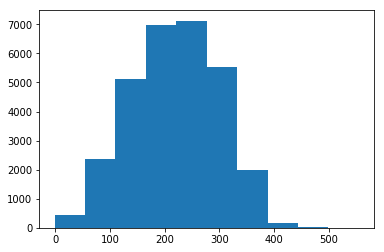

In [11]:
plt.hist(comp_scores)

In [12]:
df_comp.describe()

,actual_time,match_number,post_result_time,predicted_time,set_number,time,red_score,blue_score
count,1.362400e+04,14870.000000,1.362100e+04,1.291900e+04,14870.0,1.393800e+04,14870.000000,14870.000000
mean,1.491457e+09,38.888904,1.491457e+09,1.491310e+09,1.0,1.491805e+09,220.332482,221.137929
std,3.925681e+06,25.525540,3.926074e+06,3.764505e+06,0.0,4.578264e+06,77.294521,77.383571
min,1.487445e+09,1.000000,1.487446e+09,1.488550e+09,1.0,1.487426e+09,-1.000000,-1.000000
25%,1.489333e+09,17.000000,1.489333e+09,1.489281e+09,1.0,1.489446e+09,165.000000,165.000000
50%,1.490462e+09,36.000000,1.490462e+09,1.490455e+09,1.0,1.490468e+09,220.000000,225.000000
75%,1.491606e+09,58.000000,1.491607e+09,1.491603e+09,1.0,1.491662e+09,280.000000,280.000000
max,1.510436e+09,128.000000,1.510436e+09,1.510436e+09,1.0,1.510431e+09,555.000000,515.000000


In [13]:
comp_scores.describe()

count    29740.000000
mean       220.735205
std         77.338807
min         -1.000000
25%        165.000000
50%        221.000000
75%        280.000000
max        555.000000
dtype: float64

In [15]:
events_df = events(year=2017)

https://www.thebluealliance.com/api/v3/events/2017 200


In [18]:
joined = df.join(events_df[['week','district']], on='event_key')

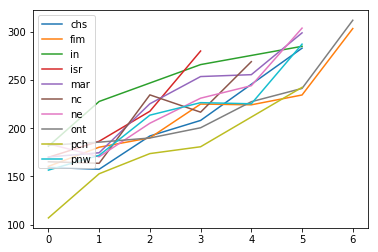

In [42]:
s = joined[['red_score', 'week', 'district']][joined['comp_level'] == 'qm'].groupby(['district', 'week']).mean()
for i in s.index.get_level_values('district').unique():
    plt.plot(s.loc[i], label=i)
plt.legend(loc='upper left')

In [39]:
s.index.get_level_values('district').unique()

Index(['chs', 'fim', 'in', 'isr', 'mar', 'nc', 'ne', 'ont', 'pch', 'pnw'], dtype='object', name='district')

In [55]:
# %load '/home/wes/dev/frc/tba-pydata/tba_pydata/analysis.py'
"""
Created on Wed Feb 14 19:21:30 2018

@author: wes
"""
import pandas
import statsmodels.api as sm


def get_opr_matrices(df):
    df = df[['key', 'red_score', 'blue_score', 'red1', 'red2', 'red3', 'blue1', 'blue2', 'blue3']]
    melted = pandas.melt(df, ['key', 'red_score', 'blue_score']).sort_values('value')
    teams = melted.value.unique()
    scores = pandas.melt(df[['key', 'red_score', 'blue_score']], ['key']).sort_values('key')
    scores.index = scores.key + '_' + scores.variable
    oprmat = pandas.DataFrame(0, index=scores.key + '_' + scores.variable, columns=teams)

    for (i, record) in melted.iterrows():
        if record.variable.startswith('blue'): oprmat.loc[record.key + '_blue_score', record.value] = 1
        if record.variable.startswith('red'): oprmat.loc[record.key + '_red_score', record.value] = 1

    return oprmat, teams, scores


def get_opr_model(df, fit=True):
    oprmat, teams, scores = get_opr_matrices(df)
    reg = sm.OLS(scores.value, oprmat)

    if fit:
        return reg.fit()
    else:
        return reg

In [59]:
chs = matches(district="2016chs")

https://www.thebluealliance.com/api/v3/district/2016chs/events/keys 200
https://www.thebluealliance.com/api/v3/event/2016mdblr/matches 200
https://www.thebluealliance.com/api/v3/event/2016vapor/matches 200
https://www.thebluealliance.com/api/v3/event/2016mdbet/matches 200
https://www.thebluealliance.com/api/v3/event/2016vabla/matches 200
https://www.thebluealliance.com/api/v3/event/2016vahay/matches 200
https://www.thebluealliance.com/api/v3/event/2016vados/matches 200
https://www.thebluealliance.com/api/v3/event/2016chcmp/matches 200
https://www.thebluealliance.com/api/v3/event/2016mdedg/matches 200


In [60]:
lm = get_opr_model(chs[chs.comp_level == 'qm'])
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     8.261
Date:                Mon, 26 Feb 2018   Prob (F-statistic):           1.57e-96
Time:                        00:51:18   Log-Likelihood:                -5437.2
No. Observations:                1264   AIC:                         1.114e+04
Df Residuals:                    1132   BIC:                         1.182e+04
Df Model:                         131                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
frc1080       18.2591      3.978      4.590      0.000      10.453      26.065
frc1086       38.8263      3.239     11.988      0.000      32.472      45.181
frc1111       28.0585      3.236      8.670      0.000      21.709      34.408
frc1123       18.5193      3.950      4.688      0.000      10.769      26.270
frc1137       32.3514      3.237      9.993      0.000      25.999      38.703
frc116        24.2385      3.235      7.493      0.000      17.891      30.586
frc122        40.1787      3.241     12.398      0.000      33.820      46.537
frc1262       31.4514      3.236      9.720      0.000      25.103      37.800
frc1389       24.6580      3.244      7.600      0.000      18.293      31.023
frc1413       28.9233      3.241      8.925      0.000      22.565      35.282
frc1418       38.9564      3.227     12.073      0.000      32.625      45.287
frc1446        5.1836      3.972      1.305      0.192      -2.610      12.977
frc1522       19.2134      3.953      4.860      0.000      11.457      26.970
frc1541       16.9011      3.973      4.254      0.000       9.106      24.696
frc1598       23.5525      3.973      5.928      0.000      15.757      31.348
frc1599       31.4931      3.236      9.732      0.000      25.144      37.842
frc1610       32.0069      3.232      9.902      0.000      25.665      38.349
frc1629       34.1524      3.237     10.551      0.000      27.802      40.503
frc1719       26.9179      3.240      8.309      0.000      20.561      33.274
frc1731       34.1963      3.234     10.573      0.000      27.850      40.542
frc1793       24.7215      3.959      6.245      0.000      16.955      32.488
frc1829       31.3197      3.232      9.690      0.000      24.978      37.661
frc1885       27.5141      3.232      8.512      0.000      21.172      33.856
frc1895       23.7791      3.241      7.338      0.000      17.421      30.137
frc1908       16.3489      3.972      4.116      0.000       8.555      24.143
frc1915       14.0803      3.965      3.551      0.000       6.301      21.859
frc2028       31.5408      3.251      9.701      0.000      25.162      37.920
frc2068       29.1973      3.230      9.039      0.000      22.860      35.535
frc2106       10.5673      3.965      2.665      0.008       2.787      18.347
frc2107       14.7717      3.956      3.734      0.000       7.010      22.533
frc2186        4.4809      3.942      1.137      0.256      -3.254      12.216
frc2199       16.3845      3.969      4.129      0.000       8.598      24.171
frc2363       33.6870      3.229     10.432      0.000      27.351      40.023
frc2377       32.9037      3.238     10.163      0.000      26.551      39.256
frc2421       23.7513      3.234      7.343      0.000      17.405      30.097
frc2528       29.1087      3.951      7.367      0.000      21.356      36.862
fr

In [61]:
lm.params.sort_values()

frc4538     0.127886
frc2911     0.761508
frc5549     1.972915
frc2890     2.418741
frc620      3.413562
frc2963     3.975513
frc2186     4.480934
frc5569     4.816509
frc1446     5.183607
frc4099     6.247864
frc5954     7.558635
frc2819     7.621694
frc617      7.795276
frc611      8.660064
frc4949     9.321673
frc4969     9.709559
frc3274    10.479552
frc2106    10.567297
frc4514    10.859470
frc5830    11.396779
frc4821    11.431319
frc3748    11.806637
frc5979    12.042251
frc614     12.105429
frc3168    13.025117
frc2964    13.368371
frc53      13.540209
frc4714    13.829503
frc6021    13.903386
frc1915    14.080308
             ...    
frc888     29.169923
frc2068    29.197265
frc3872    29.284039
frc2849    29.330541
frc2537    29.634009
frc4945    29.649814
frc4505    29.653682
frc623     29.970462
frc339     30.173138
frc1829    31.319718
frc1262    31.451429
frc1599    31.493130
frc2028    31.540846
frc1610    32.006887
frc1137    32.351358
frc3389    32.860185
frc2377    32

(array([ 4.,  6.,  9., 20., 19., 11., 26., 19., 16.,  8.]),
 array([ -7.92038571,   4.40016277,  16.72071125,  29.04125974,
         41.36180822,  53.68235671,  66.00290519,  78.32345367,
         90.64400216, 102.96455064, 115.28509912]),
 <a list of 10 Patch objects>)

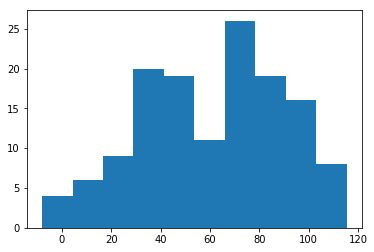

In [58]:
plt.hist(lm.params)